<a href="https://colab.research.google.com/github/probabll/dgm4nlp/blob/master/notebooks/sentencevae/SentVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import os
import re
import urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In this notebook you will work with a deep generative language model that maps sentences from a continuous latent space. We will use text data in English and pytorch. 

The first section concerns data manipulation and data loading classes necessary for our implementation. You do not need to modify anything in this part of the code, but it is useful to read through as it might illustrate some good practices.

Let's first download the Penn Treebank dataset that we will be using for this notebook: these are the sentences in the PTB English corpus.

In [2]:
url = "https://raw.githubusercontent.com/jhcross/span-parser/master/data/"
train_file = "02-21.10way.clean"
val_file = "22.auto.clean"
test_file = "23.auto.clean"

print("Downloading data files...")
if not os.path.isfile(train_file):
    urllib.request.urlretrieve(url + train_file, filename=train_file)
if not os.path.isfile(val_file):
    urllib.request.urlretrieve(url + val_file, filename=val_file)
if not os.path.isfile(test_file):
    urllib.request.urlretrieve(url + test_file, filename=test_file)
print("Download complete.")

Download complete.


# Data

In order to work with text data, we need to transform the text into something that our algorithms can work with. The first step of this process is converting words into word ids. We do this by constructing a vocabulary from the data, assigning a new word id to each new word it encounters.

In [3]:
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"


def tokens_from_treestring(s):
    """
    Removes the parse trees in the PTB dataset.
    """
    return " ".join(re.findall(r"\([A-Z]* ([^\(\)]+)\)", s))


class Vocabulary:
    
    def __init__(self):
        self.idx_to_word = {0: UNK_TOKEN, 1: PAD_TOKEN, 2: SOS_TOKEN, 3: EOS_TOKEN}
        self.word_to_idx = {UNK_TOKEN: 0, PAD_TOKEN: 1, SOS_TOKEN: 2, EOS_TOKEN: 3}
        self.word_freqs = {}
    
    def __getitem__(self, key):
        return self.word_to_idx[key] if key in self.word_to_idx else self.word_to_idx[UNK_TOKEN]
    
    def word(self, idx):
        return self.idx_to_word[idx]
    
    def size(self):
        return len(self.word_to_idx)
    
    @staticmethod
    def from_data(filenames):
        """
            Creates a vocabulary from a list of data files. It assumes that the data files have been
            tokenized and pre-processed beforehand.
        """
        vocab = Vocabulary()
        for filename in filenames:
            with open(filename) as f:
                for line in f:
                    
                    # Strip whitespace and the newline symbol.
                    line = tokens_from_treestring(line.strip())
                    
                    # Split the sentences into words and assign word ids to each
                    # new word it encounters.
                    for word in line.split():
                        if word not in vocab.word_to_idx:
                            idx = len(vocab.word_to_idx)
                            vocab.word_to_idx[word] = idx
                            vocab.idx_to_word[idx] = word
                            
        return vocab

In [4]:
# Construct a vocabulary from the training and validation data.
print("Constructing vocabulary...")
vocab = Vocabulary.from_data([train_file, val_file])
print("Constructed a vocabulary of %d word types" % vocab.size())

Constructing vocabulary...
Constructed a vocabulary of 45233 word types


In [5]:
# some examples
print('the', vocab['the'])
print('the', vocab['thing'])
print('VAE', vocab['VAE'])  # something UNKNOWN

the 20
the 630
VAE 0


We also need to load the data files into memory. We create a simple class `TextDataset` that stores the data as a list of sentences:

In [6]:
class TextDataset(Dataset):
    """
        A simple class that loads a list of sentences into memory from a text file,
        split by newlines. This does not do any memory optimisation, 
        so if your dataset is very large, you might want to use an alternative 
        class.
    """
    
    def __init__(self, text_file, max_len=30):
        self.data = []
        with open(text_file) as f:
            for line in f:
                sentence = tokens_from_treestring(line.strip())
                if len(sentence.split()) <= max_len:
                    self.data.append(sentence)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
# Load the training, validation, and test datasets into memory.
train_dataset = TextDataset(train_file)
val_dataset = TextDataset(val_file)
test_dataset = TextDataset(test_file)

# Print some samples from the data:
print("Sample from training data: \"%s\"" % train_dataset[np.random.choice(len(train_dataset))])
print("Sample from validation data: \"%s\"" % val_dataset[np.random.choice(len(val_dataset))])
print("Sample from test data: \"%s\"" % test_dataset[np.random.choice(len(test_dataset))])

Sample from training data: "Mr. Lloyd said if Qintex had defaulted it could have been required to repay 92 million in debt under loan agreements"
Sample from validation data: "For us institutional investors the chance for buying has come"
Sample from test data: "Thomson missile products with about half British Aerospace 's annual revenue include the Crotale surface-to-air missile family"


Now it's time to write a function that converts a sentence into a list of word ids using the vocabulary we created before. This function is `create_batch` in the code cell below. This function creates a batch from a list of sentences, and makes sure that each sentence starts with a start-of-sentence symbol and ends with an end-of-sentence symbol. Because not all sentences are of equal length in a certain batch, sentences are padded with padding symbols so that they match the length of the largest sentence in the batch. The function returns an input batch, an output batch, a mask of 1s for words and 0s for padding symbols, and the sequence lengths of each sentence in the batch. The output batch is shifted by one word, to reflect the predictions that the model is expected to make. For example, for a sentence
\begin{align}
    \text{The dog runs .}
\end{align}
the input sequence is
\begin{align}
    \text{SOS The dog runs .}
\end{align}
and the output sequence is
\begin{align}
    \text{The dog runs . EOS}
\end{align}

You can see the output is shifted wrt the input, that's because we will be computing a distribution for the next word in context of its prefix, and that's why we need to shift the sequence this way.


Lastly, we create an inverse function `batch_to_sentences` that recovers the list of sentences from a padded batch of word ids to use during test time.

In [8]:
def create_batch(sentences, vocab, device, word_dropout=0.):
    """
    Converts a list of sentences to a padded batch of word ids. Returns
    an input batch, an output batch shifted by one, a sequence mask over
    the input batch, and a tensor containing the sequence length of each
    batch element.
    :param sentences: a list of sentences, each a list of token ids
    :param vocab: a Vocabulary object for this dataset
    :param device: 
    :param word_dropout: rate at which we omit words from the context (input)
    :returns: a batch of padded inputs, a batch of padded outputs, mask, lengths
    """
    tok = np.array([[SOS_TOKEN] + sen.split() + [EOS_TOKEN] for sen in sentences])
    seq_lengths = [len(sen)-1 for sen in tok]
    max_len = max(seq_lengths)
    pad_id = vocab[PAD_TOKEN]
    pad_id_input = [
        [vocab[sen[t]] if t < seq_lengths[idx] else pad_id for t in range(max_len)]
            for idx, sen in enumerate(tok)]
    
    # Replace words of the input with <unk> with p = word_dropout.
    if word_dropout > 0.:
        unk_id = vocab[UNK_TOKEN]
        word_drop =  [
            [unk_id if (np.random.random() < word_dropout and t < seq_lengths[idx]) else word_ids[t] for t in range(max_len)] 
                for idx, word_ids in enumerate(pad_id_input)]
    
    # The output batch is shifted by 1.
    pad_id_output = [
        [vocab[sen[t+1]] if t < seq_lengths[idx] else pad_id for t in range(max_len)]
            for idx, sen in enumerate(tok)]
    
    # Convert everything to PyTorch tensors.
    batch_input = torch.tensor(pad_id_input)
    batch_output = torch.tensor(pad_id_output)
    seq_mask = (batch_input != vocab[PAD_TOKEN])
    seq_length = torch.tensor(seq_lengths)
    
    # Move all tensors to the given device.
    batch_input = batch_input.to(device)
    batch_output = batch_output.to(device)
    seq_mask = seq_mask.to(device)
    seq_length = seq_length.to(device)
    
    return batch_input, batch_output, seq_mask, seq_length


def batch_to_sentences(tensors, vocab: Vocabulary):
    """
    Converts a batch of word ids back to sentences.
    :param tensors: [B, T] word ids
    :param vocab: a Vocabulary object for this dataset
    :returns: an array of strings (each a sentence).
    """
    sentences = []
    batch_size = tensors.size(0)
    for idx in range(batch_size):
        sentence = [vocab.word(t.item()) for t in tensors[idx,:]]
        
        # Filter out the start-of-sentence and padding tokens.
        sentence = list(filter(lambda t: t != PAD_TOKEN and t != SOS_TOKEN, sentence))
        
        # Remove the end-of-sentence token and all tokens following it.
        if EOS_TOKEN in sentence:
            sentence = sentence[:sentence.index(EOS_TOKEN)]
            
        sentences.append(" ".join(sentence))
    return np.array(sentences)

In PyTorch the RNN functions expect inputs to be sorted from long sentences to shorter ones. Therefore we create a simple wrapper class for the DataLoader class that sorts sentences from long to short:  

In [9]:
class SortingTextDataLoader:
    """
    A wrapper for the DataLoader class that sorts a list of sentences by their
    lengths in descending order.
    """

    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.it = iter(dataloader)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        sentences = None
        for s in self.it:
            sentences = s
            break

        if sentences is None:
            self.it = iter(self.dataloader)
            raise StopIteration
        
        sentences = np.array(sentences)
        sort_keys = sorted(range(len(sentences)), 
                           key=lambda idx: len(sentences[idx].split()), 
                           reverse=True)
        sorted_sentences = sentences[sort_keys]
        return sorted_sentences

# Model

## Deterministic language model

In language modelling, we model a sentence $x = \langle x_1, \ldots, x_n \rangle$  of length $n = |x|$ as a sequence of categorical draws:

\begin{align}
X_i|x_{<i} & \sim \text{Cat}(f(x_{<i}; \theta)) 
& i = 1, \ldots, n \\
\end{align}

where we use $x_{<i}$ to denote a (possibly empty) prefix string, and thus the model makes no Markov assumption. We map from the conditioning context, the prefix $x_{<i}$, to the categorical parameters (a $v$-dimensional probability vector, where $v$ denotes the size of the vocabulary of the language) using a fixed neural network architecture whose parameters we collectively denote by $\theta$.

This assigns the following likelihood to the sentence
\begin{align}
    P(x|\theta) &= \prod_{i=1}^n P(x_i|x_{<i}, \theta) \\
    &= \prod_{i=1}^n \text{Cat}(x_i|f(x_{<i}; \theta))  
\end{align}
where the categorical pmf is $\text{Cat}(k|\pi) = \prod_{j=1}^v \pi_j^{[k=j]} = \pi_k$. 


Suppose we have a dataset $\mathcal D = \{x^{(1)}, \ldots, x^{(N)}\}$ containing $N$ i.i.d. observations. Then we can use the log-likelihood function 
\begin{align}
\mathcal L(\theta|\mathcal D) &= \sum_{k=1}^{N} \log P(x^{(k)}| \theta) \\
&= \sum_{k=1}^{N} \sum_{i=1}^{|x^{(k)}|} \log \text{Cat}(x^{(k)}_i|f(x^{(k)}_{<i}; \theta))
\end{align}
 to estimate $\theta$ by maximisation:
 \begin{align}
 \theta^\star = \arg\max_{\theta \in \Theta} \mathcal L(\theta|\mathcal D) ~ .
 \end{align}
 

We can use stochastic gradient-ascent to find a local optimum of $\mathcal L(\theta|\mathcal D)$, which only requires a gradient estimate:

\begin{align}
\nabla_\theta \mathcal L(\theta|\mathcal D) &= \sum_{k=1}^{|\mathcal D|} \nabla_\theta  \log P(x^{(k)}|\theta) \\ 
&= \sum_{k=1}^{|\mathcal D|} \frac{1}{N} N \nabla_\theta  \log P(x^{(k)}| \theta)  \\
&= \mathbb E_{\mathcal U(1/N)} \left[ N \nabla_\theta  \log P(x^{(K)}| \theta) \right]  \\
&\overset{\text{MC}}{\approx} \frac{N}{M} \sum_{m=1}^M \nabla_\theta  \log P(x^{(k_m)}|\theta) \\
&\text{where }K_m \sim \mathcal U(1/N)
\end{align}

This is a Monte Carlo (MC) estimate of the gradient computed on $M$ data points selected uniformly at random from $\mathcal D$.

For as long as $f$ remains differentiable wrt to its inputs and parameters, we can rely on automatic differentiation to obtain gradient estimates.


An example design for $f$ is:
\begin{align}
\mathbf x_i &= \text{emb}(x_i; \theta_{\text{emb}}) \\
\mathbf h_0 &\in \theta_{\text{rnn}} \\
\mathbf h_i &= \text{rnn}(\mathbf h_{i-1}, \mathbf x_{i-1}; \theta_{\text{rnn}}) \\
f(x_{<i}; \theta) &= \text{softmax}(\text{dense}_v(\mathbf h_{i};  \theta_{\text{out}}))
\end{align}
where 
* $\text{emb}$ is a fixed embedding layer with parameters $\theta_{\text{emb}}$;
* $\text{rnn}$ is a recurrent architecture with parameters $\theta_{\text{rnn}}$, e.g. an LSTM or GRU, and $\mathbf h_0$ is part of the architecture's parameters;
* $\text{dense}_v$ is a dense layer with $v$ outputs (vocabulary size) and parameters $\theta_{\text{out}}$.



In what follows we show how to extend this model with a continuous latent sentence embedding.

## Deep generative language model

We want to model a sentence $x$ as a draw from the marginal of deep generative model $p(z, x|\theta) = p(z)P(x|z, \theta)$. Note that we use $p(\cdot)$ for pdfs and $P(\cdot)$ for pmfs.


### Generative model

The generative story is:
\begin{align}
    Z & \sim \mathcal N(0, I) \\
    X_i | z, x_{<i} &\sim \text{Cat}(f(z, x_{<i}; \theta)) & i=1, \ldots, n
\end{align}
where $z \in \mathbb R^D$ and  we impose a standard Gaussian prior on latent space. Other choices of prior can induce interesting properties in latent space, however, in this notebook, we use the Gaussian for its simplicity.

It is easy to design $f$ by a simple modification of the deterministic design shown before:
\begin{align}
\mathbf x_i &= \text{emb}(x_i; \theta_{\text{emb}}) \\
\mathbf h_0 &= \tanh(\text{dense}(z; \theta_{\text{init}})) \\
\mathbf h_i &= \text{rnn}(\mathbf h_{i-1}, \mathbf x_{i-1}; \theta_{\text{rnn}}) \\
f(x_{<i}; \theta) &= \text{softmax}(\text{dense}_v(\mathbf h_{i};  \theta_{\text{out}}))
\end{align}
where we just initialise the recurrent cell using $z$. Note we could also use $z$ in other places, for example, as additional input to every update of the recurrent cell $\mathbf h_i = \text{rnn}(\mathbf h_{i-1}, [\mathbf x_{i-1}, z])$. This is an architecture choice which like many others can only be judged empirically or on the basis of practical convenience.



### Parameter estimation

The marginal likelihood, necessary for parameter estimation, is now no longer tractable:
\begin{align}
P(x|\theta) &= \int p(z)P(x|z, \theta) \text{d}z \\
&= \int \mathcal N(z|0, I)\prod_{i=1}^n \text{Cat}(x_i|f(z,x_{<i}; \theta) )\text{d}z 
\end{align}
the intractability is clear as even if $f$ would be linear (recall it isn't) the Gaussian and the Categorical are not conjugate and the integration has no closed-form solution.

We turn to variational inference and derive a lowerbound $\mathcal E(\theta, \lambda|\mathcal D)$ on the log-likelihood function

\begin{align}
    \mathcal E(\theta, \lambda|\mathcal D) &= \sum_{k=1}^{|\mathcal D|} \mathcal E_k(\theta, \lambda|x^{(k)}) 
\end{align}

which for a single datapoint $x$ is
\begin{align}
    \mathcal E(\theta, \lambda|x) &= \mathbb{E}_{q(z|x)}\left[\log P(x|z, \theta)\right] - \text{KL}\left(q(z|x, \lambda)||p(z)\right)\\
\end{align}
where we have introduce an independently parameterised auxiliary distribution $q(z|x, \lambda)$. The distribution $q$ which maximises this *evidence lowerbound* (ELBO) is also the distribution that minimises 
\begin{align}
\text{KL}(q(z|x, \lambda)||p(z|x, \theta)) = \mathbb E_{q(z|x, \lambda)}\left[ \frac{q(z|x, \lambda)}{p(z|x, \theta)}\right]
\end{align}
 where $p(z|x, \theta) = \frac{p(x, z|\theta)}{p(x|\theta)}$ is our intractable true posterior. For that reason, we think of $q(z|x, \lambda)$ as an *approximate posterior*. 
 
 The approximate posterior is an independent model of the latent variable given the data, for that reason we also call it an *inference model*. 
 In this notebook, our inference model will be a diagonal Gaussian, to make sure that we cover the sample space of our latent variable. A diagonal Gaussian models each component of the latent representation independently, and is an example of mean field (MF) inference:
 
 \begin{align}
    q(z|x, \lambda) &\overset{\text{MF}}{=} \prod_{d=1}^D \mathcal N(z_d|\mu_d(x; \lambda); \sigma_d(x; \lambda)^2) \\
    &= \mathcal N(z|\mu(x; \lambda), \text{diag}(\sigma(x; \lambda)^2))
 \end{align}
 
 where we employ neural network architectures to map from the sentence $x$ to a vector of locations (in $\mathbb R^D$) and a vector of scales (in $\mathbb R^D_{>0}$).
 
 
For this choice, the KL term in the ELBO is tractable:

\begin{align}
\text{KL}\left(q(z|x, \lambda)||p(z)\right) &= \sum_{d=1}^D \text{KL}\left(q(z_d|x, \lambda)||p(z_d)\right) \\
&= \sum_{d=1}^D \text{KL}\left(\mathcal N(u_d, s^2)|| \mathcal N(0,1)\right) \\
&= - \frac{1}{2} \sum_{d=1}^D \left(1 + \log s_d^2 - u_d^2 - s_d^2 \right)
\end{align}
where $u_d = \mu_d(x; \lambda)$ and $s_d = \sigma_d(x; \lambda)$.

 
Here's an example design for our inference model:

\begin{align}
\mathbf x_i &= \text{emb}(x_i; \lambda_{\text{emb}}) \\
\mathbf f_i &= \text{rnn}(\mathbf f_{i-1}, \mathbf x_{i}; \lambda_{\text{fwd}}) \\
\mathbf b_i &= \text{rnn}(\mathbf b_{i+1}, \mathbf x_{i}; \lambda_{\text{bwd}}) \\
\mathbf h &= \text{dense}([\mathbf f_{n}, \mathbf b_1]; \lambda_{\text{hid}}) \\
\mu(x; \lambda) &= \text{dense}(\mathbf h; \lambda_{\text{loc}})\\
\sigma(x; \lambda) &= \text{softplus}(\text{dense}(\mathbf h; \lambda_{\text{scale}}))
\end{align}

where we use the $\text{softplus}$ activation to make sure our scales are strictly positive. Note that $\exp$ would also do that job, though $\text{softplus}$ is assymptotically linear with its input, which gives us better gradient dynamics.
 
Because we have neural networks compute the diagonal Gaussian parameters for us, we call this *amortised* mean field inference.



### Gradient estimation

We have to obtain gradients of the ELBO

\begin{align}
\nabla_\theta  \mathcal E(\theta, \lambda|x) &=  \mathbb{E}_{q(z|x)}\left[\nabla_\theta \log P(x|z, \theta)\right] - \underbrace{\nabla_\theta \text{KL}\left(q(z|x, \lambda)||p(z)\right)}_{=0}
\end{align}

and 

\begin{align}
\nabla_\lambda  \mathcal E(\theta, \lambda|x) &= \nabla_\lambda\mathbb{E}_{q(z|x)}\left[\log P(x|z, \theta)\right] - \nabla_\lambda \text{KL}\left(q(z|x, \lambda)||p(z)\right)
\end{align}

Clearly, the gradient for the generative network is easy to estimate using MC, but the gradient for the inference network is more complicated because we don't have an expected gradient, rather the gradient of an expected value.

But recall, that we chose a Gaussian for approximate posterior, and Gaussians are what we call a location-scale family. Every Gaussian variable can be *re-expressed* or  **reparameterised** in terms of the standard Gaussian (a distribution with fixed parameters), that is:

\begin{align}
\epsilon = \frac{z - \mu(x; \sigma)}{\sigma(x; \lambda)} &\sim \mathcal N(0, I) \\
z = \mu(x; \lambda) + \sigma(x;\lambda) \odot \epsilon &\sim \mathcal N(\mu(x; \lambda), \text{diag}(\sigma(x; \lambda)^2))
\end{align}

where $\epsilon$ is distributed by a $D$-dimensional standard Gaussian and $\odot$ denotes elementwise multiplication.

This means we can rewrite the ELBO as

\begin{align}
\mathcal E(\theta, \lambda|x) &= \mathbb{E}_{\epsilon \sim \mathcal N(0, I)}\left[\log P(x|z=\mu(x; \lambda) + \sigma(x; \lambda) \odot \epsilon, \theta)\right] - \text{KL}\left(q(z|x, \lambda)||p(z)\right) 
\end{align}

and though we could also rewrite the KL term, we will leave as is because it is tractable to compute.

Now our gradients are both very simple:

\begin{align}
\nabla_\theta \mathcal E(\theta, \lambda|x) &= \mathbb{E}_{\epsilon \sim \mathcal N(0, I)}\left[\nabla_\theta \log P(x|z=\mu(x; \lambda) + \sigma(x; \lambda) \odot \epsilon, \theta)\right] - \underbrace{\nabla_\theta \text{KL}\left(q(z|x, \lambda)||p(z)\right)}_{=0} \\
&\overset{\text{MC}}{\approx} \frac{1}{S} \sum_{s=1}^S \nabla_\theta \log P(x|z^{(s)}, \theta) \\
&\text{where }z^{(s)} = \mu(x; \lambda) + \sigma(x; \lambda) \odot \epsilon^{(s)}\\
&\text{and }\epsilon^{(s)} \sim \mathcal N(0, I)
\end{align}

and 

\begin{align}
\nabla_\lambda \mathcal E(\theta, \lambda|x) &=\nabla_\lambda \mathbb{E}_{\epsilon \sim \mathcal N(0, I)}\left[\nabla_\lambda \log P(x|z=\mu(x; \lambda) + \sigma(x; \lambda) \odot \epsilon, \theta)\right] - \nabla_\lambda \underbrace{\text{KL}\left(q(z|x, \lambda)||p(z)\right)}_{\text{tractable}} \\
&\overset{\text{MC}}{\approx} \left(\frac{1}{S} \sum_{s=1}^S \nabla_\lambda \log P(x|z^{(s)}, \theta)\right) -  \nabla_\lambda \underbrace{\text{KL}\left(q(z|x, \lambda)||p(z)\right)}_{\text{tractable}}\\
&\text{where }z^{(s)} = \mu(x; \lambda) + \sigma(x; \lambda) \odot \epsilon^{(s)}\\
&\text{and }\epsilon^{(s)} \sim \mathcal N(0, I)
\end{align}

and note how both, but especially the second, use this notion of *reparameterised sample* to make all sources of stochasticity independent of the parameters of the network.

Gradient estimates of this sort are known in the literature as *reparameterised gradients* and this makes our model an instance of what is known in the literature as a *variational auto-encoder* (VAE).




## Implementation

We start by implementing our generative model, which requires implementing a Gaussian/Normal distribution:

Check the [wikipedia page about Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) for information such as the functional form of the pdf. 

You will need the KL divergence for univariate Normal distributions:

\begin{align}
\text{KL}\left(\mathcal N(\mu_1, \sigma_1^2) || \mathcal N(\mu_2, \sigma_2^2)\right)
&= \frac{1}{2 \sigma_2^2} \left((\mu_1 - \mu_2)^2 + \sigma_1^2 - \sigma_2^2\right) + \log \frac{\sigma_2}{\sigma_1}
\end{align}




In [10]:
class Normal:
    """
    This is a normal distribution
        N(u, s^2)
    thus specified by a location u and a strictly positive scale.
    
    This class can hold a collection of D independent Gaussian variables
        by having a D-dimensional vector of locations and 
        a D-dimensinal vector of scales.        
    """
    
    def __init__(self, loc, scale):
        """
        :param loc: a tensor of locations (real numbers)
        :param scale: a tensor of scales (strictly positive real numbers)
        """
        self.loc = loc
        self.scale = scale
    
    def mean(self):
        """For Gaussians this is the location"""
        return self.loc
    
    def std(self):
        """For Gaussians this is the scale"""
        return self.scale
    
    def sample(self):
        """
        Returns a reparameterised sample with the shape of the location parameter.
        """
        eps = torch.randn_like(self.loc)
        return self.loc + self.scale * eps
    
    def log_pdf(self, x):
        """
        Assess the log probability density of x.
        
        :param x: a tensor of Gaussian samples (same shape as the location parameter)
        :returns:  tensor of log probabilitie densities
        """
        return -0.5 * (x - self.loc) ** 2 / self.scale ** 2 - 0.5 * torch.log(2 * np.pi * self.scale ** 2)

    def kl(self, other: 'Normal'):
        """
        The KL divergence between two Gaussians
        :returns: a tensor of KL values with the same shape as the parameters of self.
        """
        return torch.log(other.scale) - torch.log(self.scale) \
            + ((self.loc - other.loc) ** 2 + self.scale ** 2 - other.scale ** 2) / (2. * other.scale ** 2)

In [11]:
# tests for Normal
torch.manual_seed(0xBADF00D)
dummy_loc = torch.randn(10, requires_grad=True)
dummy_scale = torch.linspace(0.1, 5.0, 10, requires_grad=True)
dummy_samples = Normal(dummy_loc, dummy_scale).sample()
sample_pdf = Normal(dummy_loc, dummy_scale).log_pdf(dummy_samples)

dummy_grads = torch.autograd.grad(dummy_samples.mean(), [dummy_loc, dummy_scale], allow_unused=True)
assert all(grad is not None for grad in dummy_grads), "samples are not differentiable w.r.t. loc and/or scale. "\
                                                      " Make sure you use torch throughout the implementation "
assert sample_pdf.shape == dummy_loc.shape

# kl divergence
dummy_loc_2 = torch.randn(10, requires_grad=True)

normal1 = Normal(dummy_loc, dummy_scale)
normal2 = Normal(dummy_loc_2, 5.1 - dummy_scale)
dummy_kl = normal1.kl(normal2)

dummy_kl_ref = torch.tensor([3.423, 1.468, 0.8952, 0.4297, 0.1506, 0.2868, 0.8887, 4.5, 21.904, 1355.1639])
assert dummy_kl.shape == dummy_kl_ref.shape, "please return a batch of KL divergence with the same shape as self.loc"
assert torch.allclose(dummy_kl, dummy_kl_ref, rtol=1e-3, atol=1e-3), "your KL implementation is off"

Then we should implement the inference model $q(z | x, \lambda)$:

In [12]:
class InferenceModel(nn.Module):

    def __init__(self, vocab_size, embedder, hidden_size,
                 latent_size, pad_idx, bidirectional=False):
        """
        Implement the layers in the inference model.
        
        :param vocab_size: size of the vocabulary of the language
        :param embedder: embedding layer
        :param hidden_size: size of recurrent cell
        :param latent_size: size D of the latent variable
        :param pad_idx: id of the -PAD- token
        :param bidirectional: whether we condition on x via a bidirectional or 
          unidirectional encoder          
        """
        super(InferenceModel, self).__init__()
        self.embedder = embedder
        self.vocab_size = vocab_size
        self.lstm = nn.LSTM(embedder.embedding_dim, hidden_size, bidirectional=bidirectional, batch_first=True)
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.linear_layer = nn.Linear(lstm_output_size, 2 * latent_size)
        self.loc_model = nn.Linear(2 * latent_size, latent_size)
        self.scale_model = nn.Sequential(
            nn.Linear(2 * latent_size, latent_size),
            nn.Softplus()
        )        

    def forward(self, x, seq_mask, seq_len) -> Normal:
        """
        Return an inference Gaussian per instance in the mini-batch
        :param x: sentences [B, T] as token ids
        :param seq_mask: indicates valid positions vs padding positions [B, T]
        :param seq_len: the length of the sequences [B]
        :return: Gaussian approximate posterior
        """
        
        embeddings = self.embedder(x).detach()
        h, final_state = self.lstm(embeddings)
        final_state = final_state[0]
        if self.lstm.bidirectional:
            final_state = torch.cat((final_state[0], final_state[1]), dim=-1)
        else:
            final_state = final_state[0]
        
        linear_output = torch.tanh(self.linear_layer(final_state))
        return Normal(self.loc_model(linear_output), self.scale_model(linear_output))

In [13]:
# tests for inference model
pad_idx = vocab.word_to_idx['<pad>']

dummy_inference_model = InferenceModel(
    vocab_size=vocab.size(),
    embedder=nn.Embedding(vocab.size(), 64, padding_idx=pad_idx),
    hidden_size=128, latent_size=16, pad_idx=pad_idx, bidirectional=True
).to(device=device)
dummy_batch_size = 32
dummy_dataloader = SortingTextDataLoader(DataLoader(train_dataset, batch_size=dummy_batch_size))
dummy_sentences = next(dummy_dataloader)

x_in, _, seq_mask, seq_len = create_batch(dummy_sentences, vocab, device)

q_z_given_x = dummy_inference_model.forward(x_in, seq_mask, seq_len)
assert isinstance(q_z_given_x, Normal), "inference model should return a Normal distribution"
assert q_z_given_x.loc.shape == q_z_given_x.scale.shape, "loc and scale must be of the same size"
assert q_z_given_x.loc.shape == (dummy_batch_size, 16), "model must produce [batch_size x latent_size] units."
assert torch.all(q_z_given_x.scale >= 0), "scale can't be negative"

Then we should implement the generative model, we call it BowmanLM after one of the [authors of the model](https://arxiv.org/abs/1511.06349).

In [14]:
class BowmanLM(nn.Module):
    
    def __init__(self, vocab_size, emb_size, hidden_size, latent_size,
                 pad_idx, dropout=0.):
        """
        :param vocab_size: size of the vocabulary of the language
        :param emb_size: dimensionality of embeddings
        :param hidden_size: dimensionality of recurrent cell
        :param latent_size: this is D the dimensionality of the latent variable z
        :param pad_idx: the id reserved to the -PAD- token
        :param dropout: a dropout rate (you can ignore this for now)
        """
        super(BowmanLM, self).__init__()
        self.embedder = nn.Embedding(
            vocab_size, emb_size, padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.bridge = nn.Linear(latent_size, hidden_size)
        self.projection = nn.Linear(hidden_size, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        
        self.pad_idx = pad_idx        
    
    def init_hidden(self, z):
        """
        Returns the hidden state of the LSTM initialized with a projection of a given z.
        :param z: [B, D]
        :returns: [B, D] hidden state, [B, D] cell state
            
        """
        h = self.bridge(z).unsqueeze(0)
        c = self.bridge(z).unsqueeze(0)
        return (h, c)
    
    def step(self, prev_x, z, hidden):
        """
        Performs a single LSTM step for a given previous word and hidden state.
        Returns the unnormalized log probabilities (logits) over the vocabulary for this time step. 
        :param prev_x: [B] id of the previous token
        :param z: [B, D] latent variable
        :param hidden:  hidden ([B, H] state, [B, H] cell)
        """
        embeddings = self.dropout(self.embedder(prev_x))
        output, h = self.lstm(embeddings, hidden)
        scores = self.projection(self.dropout(output))
        return scores, h
    
    def forward(self, x, z):
        """
        Performs an entire forward pass given a sequence of words x and a z.
        :param x: [B, T] token ids 
        :param z: [B, D] a latent sample
        """
        hidden = self.init_hidden(z)
        outputs = []
        for t in range(x.size(1)):
            prev_x = x[:, t].unsqueeze(-1)
            scores, hidden = self.step(prev_x, z, hidden)
            outputs.append(scores)
        return torch.cat(outputs, dim=1)
        
    def loss(self, scores, targets, pz, qz, free_nats=0., evaluation=False):
        """
        Computes the terms in the loss (negative ELBO) given the 
            scores (unnormalized log-probabilities), targets,
        the prior distribution p(z), and the approximate posterior distribution q(z|x).
        
        If free_nats is nonzero it will clamp the KL divergence between the posterior
        and prior to that value, preventing gradient propagation via the KL if it's
        below that value. 
        
        If evaluation is set to true, the loss will be summed instead
        of averaged over the batch. 
        
        Returns the reconstruction loss and the KL. 
        
        The loss
        can be computed from those as loss = rec_loss - KL.
        
        :returns: 
            negative log likelihood (scalar), KL (scalar)
            (use mean for training mode and sum for evaluation mode)
        """
        scores = scores.permute(0, 2, 1)
        reconstruction_loss = F.cross_entropy(
            scores,
            targets, 
            ignore_index=self.pad_idx, 
            reduction="none"
        )
        reconstruction_loss = reconstruction_loss.sum(dim=1)
        
        # Compute the KL divergence and clamp to at least the given amount of free nats.
        kl = qz.kl(pz).sum(dim=1)
        if free_nats:
            kl = torch.clamp(kl, min=free_nats)
        
        # For evaluation return the sum of individual components, for
        # training return the mean of those components.
        if evaluation:
            return reconstruction_loss.sum(), kl.sum()
        else:
            return reconstruction_loss.mean(), kl.mean()

The code below is used to assess the model and also investigate what it learned. We implemented it for you, so that you can focus on the VAE part. It's useful however to learn from this example: we do interesting things like computing perplexity and sampling novel sentences!

# Evaluation metrics

During training we'd like to keep track of some evaluation metrics on the validation data in order to keep track of how our model is doing and to perform early stopping. One simple metric we can compute is the ELBO on all the validation or test data using a single sample from the approximate posterior $q(z|x)$:

In [15]:
def eval_elbo(model, inference_model, eval_dataset, vocab, device, batch_size=128):
    """
    Computes a single sample estimate of the ELBO on a given dataset.
    """
    dl = DataLoader(eval_dataset, batch_size=batch_size)
    sorted_dl = SortingTextDataLoader(dl)
    
    # Make sure the model is in evaluation mode (i.e. disable dropout).
    model.eval()
            
    total_rec_loss = 0.
    total_KL = 0.
    num_sentences = 0
        
    # We don't need to compute gradients for this.
    with torch.no_grad():
        for sentences in sorted_dl:    
            x_in, x_out, seq_mask, seq_len = create_batch(sentences, vocab, device)
            
            # Infer the approximate posterior and construct the prior.
            qz = inference_model(x_in, seq_mask, seq_len)
            pz = Normal(torch.zeros_like(qz.mean()), 
                        torch.ones_like(qz.std()))
            
            # Compute the unnormalized probabilities using a single sample from the
            # approximate posterior.
            z = qz.sample()
            scores = model(x_in, z)
            
            # Compute the reconstruction loss and KL divergence.
            reconstruction_loss, KL = model.loss(scores, x_out, pz, qz,
                                                 free_nats=0.,
                                                 evaluation=True)
            total_rec_loss += reconstruction_loss
            total_KL += KL
            num_sentences += x_in.size(0)

    # Return the average reconstruction loss and KL.
    avg_rec_loss = total_rec_loss / num_sentences
    avg_KL = total_KL / num_sentences
    return avg_rec_loss, avg_KL

In [16]:
# test for your BowmanLM implementation with elbo. This may take a few seconds
dummy_lm = BowmanLM(vocab.size(), emb_size=64, hidden_size=128, 
                        latent_size=16, pad_idx=pad_idx).to(device=device)

!head -n 128 {val_file} > ./dummy_dataset
dummy_data = TextDataset('./dummy_dataset')
dummy_rec_loss, dummy_kl = eval_elbo(dummy_lm, dummy_inference_model,
                                     dummy_data, vocab, device)
print(dummy_rec_loss, dummy_kl)
assert dummy_rec_loss.item() > 0 and dummy_kl.item() > 0

tensor(201.0962, device='cuda:0') tensor(1.6992, device='cuda:0')



A common metric to evaluate language models is the perplexity per word. The perplexity per word for a dataset is defined as:

\begin{align}
    \text{ppl}(\mathcal{D}) = \exp\left(-\frac{1}{\sum_{k=1}^{|\mathcal D|} n^{(k)}} \sum_{k=1}^{|\mathcal{D}|} \log P(x^{(k)})\right) 
\end{align}

where $n^{(k)} = |x^{(k)}|$ is the number of tokens in a sentence and $P(x^{(k)})$ is the probability that our model assigns to the datapoint $x^{(k)}$. In order to compute $\log P(x)$ for our model we need to evaluate the integral:

\begin{align}
    P(x) = \int P(x|z) p(z) dz
\end{align}

As this is an integral  cannot be compute in closed-form, we have two options: we can use the earlier derived lower-bound on the log-likelihood, which will give us an upper-bound on the perplexity, or we can make an importance sampling estimate using our approximate posterior distribution. The importance sampling (IS) estimate can be done as:

\begin{align}
\hat P(x) &\overset{\text{IS}}{\approx} \frac{1}{S} \sum_{s=1}^{S} \frac{p(z^{(s)})p(x|z^{(s)})}{q(z^{(s)}|x)} & \text{where }z^{(s)} \sim q(z|x)
\end{align}

where $S$ is the number of samples.

Then our perplexity becomes:
\begin{align}
    &\frac{1}{\sum_{k=1}^{|\mathcal D|} n^{(k)}}  \sum_{k=1}^{|\mathcal D|} \log p(x^{(k)}) \\
    &\approx \frac{1}{\sum_{k=1}^{|\mathcal D|} n^{(k)}}  \sum_{k=1}^{|\mathcal D|} \log \frac{1}{S} \sum_{s=1}^{S} \frac{p(z^{(s)})p(x^{(k)}|z^{(s)})}{q(z^{(s)}|x^{(k)})} \\
\end{align}

We define the function `eval_perplexity` below that implements this importance sampling estimate:

In [17]:
def eval_perplexity(model, inference_model, eval_dataset, vocab, device, 
                    n_samples, batch_size=128):
    """
    Estimates the per-word perplexity using importance sampling with the
    given number of samples.
    """
    
    dl = DataLoader(eval_dataset, batch_size=batch_size)
    sorted_dl = SortingTextDataLoader(dl)
    
    # Make sure the model is in evaluation mode (i.e. disable dropout).
    model.eval()
    
    log_px = 0.
    num_predictions = 0
    num_sentences = 0
     
    # We don't need to compute gradients for this.
    with torch.no_grad():
        for sentences in sorted_dl:
            x_in, x_out, seq_mask, seq_len = create_batch(sentences, vocab, device)
            
            # Infer the approximate posterior and construct the prior.
            qz = inference_model(x_in, seq_mask, seq_len)
            pz = Normal(torch.zeros_like(qz.mean()), 
                        torch.ones_like(qz.std()))

            # Create an array to hold all samples for this batch.
            batch_size = x_in.size(0)
            log_px_samples = torch.zeros(n_samples, batch_size)
            
            # Sample log P(x) n_samples times.
            for s in range(n_samples):
                
                # Sample a z^s from the posterior.
                z = qz.sample()
                
                # Compute log P(x^k|z^s)
                scores = model(x_in, z)
                cond_log_prob = F.log_softmax(scores, dim=-1)
                cond_log_prob = torch.gather(cond_log_prob, 2, x_out.unsqueeze(-1)).squeeze() # B x T
                cond_log_prob = (cond_log_prob * seq_mask.type_as(cond_log_prob)).sum(dim=1) # B
                
                # Compute log p(z^s) and log q(z^s|x^k)
                prior_log_prob = pz.log_pdf(z).sum(dim=1) # B
                posterior_log_prob = qz.log_pdf(z).sum(dim=1) # B
                
                # Store the sample for log P(x^k) importance weighted with p(z^s)/q(z^s|x^k).
                log_px_sample = cond_log_prob + prior_log_prob - posterior_log_prob
                log_px_samples[s] = log_px_sample
                
            # Average over the number of samples and count the number of predictions made this batch.
            log_px_batch = torch.logsumexp(log_px_samples, dim=0) - \
                    torch.log(torch.Tensor([n_samples]))
            log_px += log_px_batch.sum()
            num_predictions += seq_len.sum()
            num_sentences += seq_len.size(0)

    # Compute and return the perplexity per word.
    perplexity = torch.exp(-log_px / num_predictions)
    NLL = -log_px / num_sentences
    return perplexity, NLL

Lastly, we want to occasionally qualitatively see the performance of the model during training, by letting it reconstruct a given sentence from the latent space. This gives us an idea of whether the model is using the latent space to encode some semantics about the data. For this we use a deterministic greedy decoding algorithm, that chooses the word with maximum probability at every time step, and feeds that word into the next time step.

In [18]:
def greedy_decode(model, z, vocab, max_len=50):
    """
    Greedily decodes a sentence from a given z, by picking the word with
    maximum probability at each time step.
    """
    
    # Disable dropout.
    model.eval()
    
    # Don't compute gradients.
    with torch.no_grad():
        batch_size = z.size(0)
        
        # We feed the model the start-of-sentence symbol at the first time step.
        prev_x = torch.ones(batch_size, 1, dtype=torch.long).fill_(vocab[SOS_TOKEN]).to(z.device)
        
        # Initialize the hidden state from z.
        hidden = model.init_hidden(z)

        predictions = []    
        for t in range(max_len):
            scores, hidden = model.step(prev_x, z, hidden)
            
            # Choose the argmax of the unnnormalized probabilities as the
            # prediction for this time step.
            prediction = torch.argmax(scores, dim=-1)
            predictions.append(prediction)
            
            prev_x = prediction.view(batch_size, 1)
            
        return torch.cat(predictions, dim=1)

In [19]:
# Define the model hyperparameters.
emb_size = 256
hidden_size = 256 
latent_size = 16
bidirectional_encoder = True
free_nats = 5.
annealing_steps = 11400
dropout = 0.6
word_dropout = 0.75
batch_size = 64
learning_rate = 0.001
num_epochs = 20
n_importance_samples = 3 # 50

# Create the training data loader.
dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
sorted_dl = SortingTextDataLoader(dl)

# Create the generative model.
model = BowmanLM(vocab_size=vocab.size(), 
                 emb_size=emb_size, 
                 hidden_size=hidden_size, 
                 latent_size=latent_size, 
                 pad_idx=vocab[PAD_TOKEN],
                 dropout=dropout)
model = model.to(device)

# Training

Now it's time to train the model. We use early stopping on the validation perplexity for model selection.

In [20]:
from itertools import chain

# Define the model hyperparameters.
emb_size = 256
hidden_size = 256 
latent_size = 16
bidirectional_encoder = True
free_nats = 5.
annealing_steps = 11400
dropout = 0.6
word_dropout = 0.75
batch_size = 64
learning_rate = 0.001
num_epochs = 20
n_importance_samples = 3 # 50

# Create the training data loader.
dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
sorted_dl = SortingTextDataLoader(dl)

# Create the generative model.
model = BowmanLM(vocab_size=vocab.size(), 
                 emb_size=emb_size, 
                 hidden_size=hidden_size, 
                 latent_size=latent_size, 
                 pad_idx=vocab[PAD_TOKEN],
                 dropout=dropout)
model = model.to(device)

# Create the inference model.
inference_model = InferenceModel(vocab_size=vocab.size(),
                                 embedder=model.embedder,
                                 hidden_size=hidden_size,
                                 latent_size=latent_size,
                                 pad_idx=vocab[PAD_TOKEN],
                                 bidirectional=bidirectional_encoder)
inference_model = inference_model.to(device)

# Create the optimizer.
optimizer = optim.Adam(chain(model.parameters(), inference_model.parameters()), lr=learning_rate)

# Save the best model (early stopping).
best_model = "./best_model.pt"
best_val_ppl = float("inf")
best_epoch = 0

# Keep track of some statistics to plot later.
train_ELBOs = []
train_KLs = []
val_ELBOs = []
val_KLs = []
val_perplexities = []
val_NLLs = []

step = 0
training_ELBO = 0.
training_KL = 0.
num_batches = 0
for epoch_num in range(1, num_epochs+1):    
    for sentences in sorted_dl:

        # Make sure the model is in training mode (for dropout).
        model.train()

        # Transform the sentences to input, output, seq_len, seq_mask batches.
        x_in, x_out, seq_mask, seq_len = create_batch(sentences, vocab, device,
                                                      word_dropout=word_dropout)

        # Compute the multiplier for the KL term if we do annealing.
        if annealing_steps > 0:
            KL_weight = min(1., (1.0 / annealing_steps) * step)
        else:
            KL_weight = 1.
        
        # Do a forward pass through the model and compute the training loss. We use
        # a reparameterized sample from the approximate posterior during training.
        qz = inference_model(x_in, seq_mask, seq_len)
        pz = Normal(torch.zeros_like(qz.mean()), 
                    torch.ones_like(qz.std()))
        z = qz.sample()
        scores = model(x_in, z)
        rec_loss, KL = model.loss(scores, x_out, pz, qz, free_nats=free_nats)
        loss = rec_loss + KL_weight * KL

        # Backpropagate and update the model weights.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update some statistics to track for the training loss.
        training_ELBO += -(rec_loss - KL)
        training_KL += KL
        num_batches += 1
        
        # Every 100 steps we evaluate the model and report progress.
        if step % 100 == 0:
            val_rec_loss, val_KL = eval_elbo(model, inference_model, val_dataset, vocab, device)
            val_ELBO = -(val_rec_loss - val_KL)
            print("(%d) step %d: training ELBO (KL) = %.2f (%.2f) --"
                  " KL weight = %.2f --"
                  " validation ELBO (KL) = %.2f (%.2f)" % 
                  (epoch_num, step, training_ELBO/num_batches, 
                   training_KL/num_batches, KL_weight, val_ELBO, val_KL))
            
            # Update some statistics for plotting later.
            train_ELBOs.append((step, (training_ELBO/num_batches).item()))
            train_KLs.append((step, (training_KL/num_batches).item()))
            val_ELBOs.append((step, val_ELBO.item()))
            val_KLs.append((step, val_KL.item()))
            
            # Reset the training statistics.
            training_ELBO = 0.
            training_KL = 0.
            num_batches = 0
            
        step += 1

    # After an epoch we'll compute validation perplexity and save the model
    # for early stopping if it's better than previous models.
    print("Finished epoch %d" % (epoch_num))
    val_perplexity, val_NLL = eval_perplexity(model, inference_model, val_dataset, vocab, device, 
                                              n_importance_samples)
    val_rec_loss, val_KL = eval_elbo(model, inference_model, val_dataset, vocab, device)
    val_ELBO = -(val_rec_loss - val_KL)
    
    # Keep track of the validation perplexities / NLL.
    val_perplexities.append((epoch_num, val_perplexity.item()))
    val_NLLs.append((epoch_num, val_NLL.item()))
    
    # If validation perplexity is better, store this model for early stopping.
    if val_perplexity < best_val_ppl:
        best_val_ppl = val_perplexity
        best_epoch = epoch_num
        torch.save(model.state_dict(), best_model)
        
    # Print epoch statistics.
    print("Evaluation epoch %d:\n"
          " - validation perplexity: %.2f\n"
          " - validation NLL: %.2f\n"
          " - validation ELBO (KL) = %.2f (%.2f)"
          % (epoch_num, val_perplexity, val_NLL, val_ELBO, val_KL))

    # Also show some qualitative results by reconstructing a sentence from the
    # validation data. Use the mean of the approximate posterior and greedy
    # decoding.
    random_sentence = val_dataset[np.random.choice(len(val_dataset))]
    x_in, _, seq_mask, seq_len = create_batch([random_sentence], vocab, device)
    qz = inference_model(x_in, seq_mask, seq_len)
    z = qz.mean()
    reconstruction = greedy_decode(model, z, vocab)
    reconstruction = batch_to_sentences(reconstruction, vocab)[0]
    print("-- Original sentence: \"%s\"" % random_sentence)
    print("-- Model reconstruction: \"%s\"" % reconstruction)

(1) step 0: training ELBO (KL) = -186.74 (5.00) -- KL weight = 0.00 -- validation ELBO (KL) = -197.01 (2.04)
(1) step 100: training ELBO (KL) = -132.69 (19.01) -- KL weight = 0.01 -- validation ELBO (KL) = -118.75 (16.56)
(1) step 200: training ELBO (KL) = -125.90 (11.42) -- KL weight = 0.02 -- validation ELBO (KL) = -125.40 (7.03)
(1) step 300: training ELBO (KL) = -130.62 (5.60) -- KL weight = 0.03 -- validation ELBO (KL) = -125.59 (4.68)
(1) step 400: training ELBO (KL) = -127.76 (5.03) -- KL weight = 0.04 -- validation ELBO (KL) = -123.70 (4.96)
(1) step 500: training ELBO (KL) = -126.98 (5.01) -- KL weight = 0.04 -- validation ELBO (KL) = -122.25 (4.91)
Finished epoch 1
Evaluation epoch 1:
 - validation perplexity: 1119.87
 - validation NLL: 130.44
 - validation ELBO (KL) = -122.22 (4.67)
-- Original sentence: "Kansas wheat farmers and Florida fruit growers would have to adjust or give up the California market"
-- Model reconstruction: "The company 's the company 's the company 's

(9) step 4400: training ELBO (KL) = -106.79 (5.00) -- KL weight = 0.39 -- validation ELBO (KL) = -108.89 (4.44)
(9) step 4500: training ELBO (KL) = -107.49 (5.00) -- KL weight = 0.39 -- validation ELBO (KL) = -109.59 (3.53)
(9) step 4600: training ELBO (KL) = -106.61 (5.00) -- KL weight = 0.40 -- validation ELBO (KL) = -109.81 (3.15)
(9) step 4700: training ELBO (KL) = -106.26 (5.00) -- KL weight = 0.41 -- validation ELBO (KL) = -108.37 (4.47)
Finished epoch 9
Evaluation epoch 9:
 - validation perplexity: 482.79
 - validation NLL: 114.80
 - validation ELBO (KL) = -110.16 (2.64)
-- Original sentence: "The takeover was submitted for approval by the West German cartel office BSN said"
-- Model reconstruction: "The company said it will be reached to be a lot of the company 's largest stock market"
(10) step 4800: training ELBO (KL) = -104.63 (5.00) -- KL weight = 0.42 -- validation ELBO (KL) = -108.54 (4.31)
(10) step 4900: training ELBO (KL) = -105.43 (5.00) -- KL weight = 0.43 -- validat

(18) step 9000: training ELBO (KL) = -98.76 (5.00) -- KL weight = 0.79 -- validation ELBO (KL) = -110.18 (2.02)
(18) step 9100: training ELBO (KL) = -98.38 (5.00) -- KL weight = 0.80 -- validation ELBO (KL) = -109.36 (2.93)
(18) step 9200: training ELBO (KL) = -99.09 (5.00) -- KL weight = 0.81 -- validation ELBO (KL) = -108.44 (3.87)
(18) step 9300: training ELBO (KL) = -98.13 (5.00) -- KL weight = 0.82 -- validation ELBO (KL) = -107.54 (4.73)
(18) step 9400: training ELBO (KL) = -99.65 (5.00) -- KL weight = 0.82 -- validation ELBO (KL) = -108.12 (4.05)
Finished epoch 18
Evaluation epoch 18:
 - validation perplexity: 511.62
 - validation NLL: 115.88
 - validation ELBO (KL) = -107.57 (4.58)
-- Original sentence: "This was a hangover from Friday when Standard & Poor 's 500-stock index futures had closed at a sharp discount to stocks"
-- Model reconstruction: "The company said it will be reached for the company 's largest business"
(19) step 9500: training ELBO (KL) = -98.31 (5.00) -- KL 

# Let's plot the training and validation statistics:

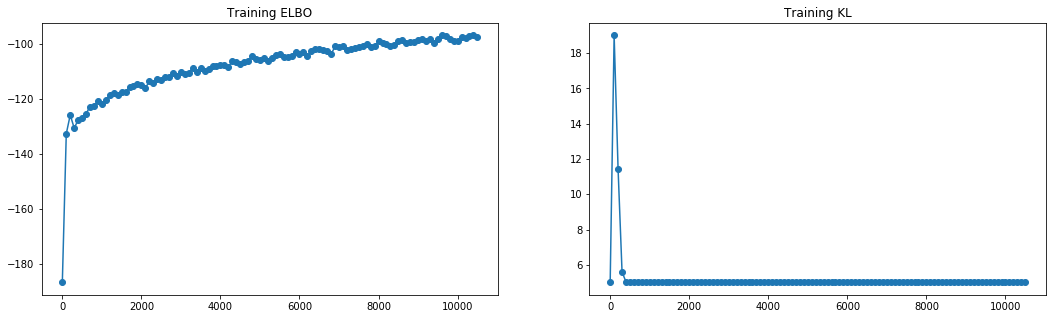

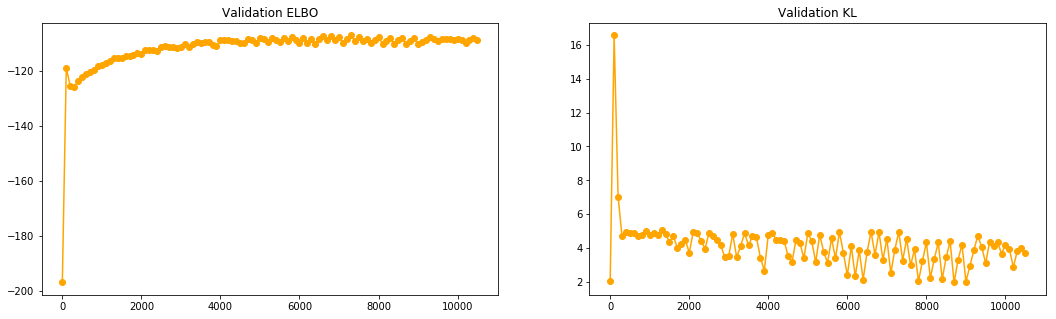

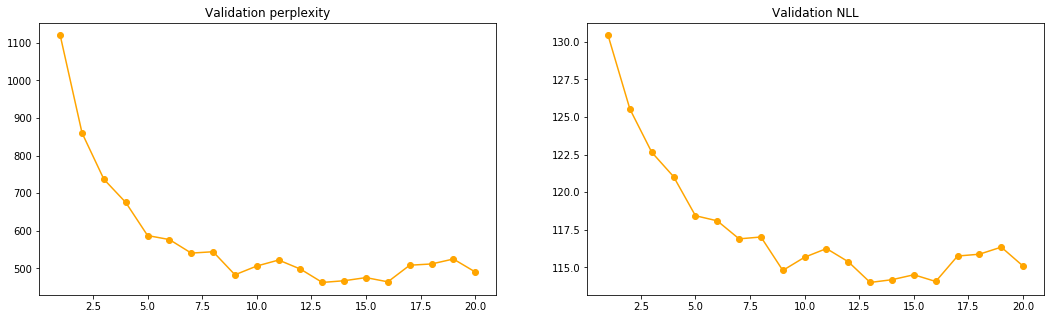

In [21]:
steps, training_ELBO = list(zip(*train_ELBOs))
_, training_KL = list(zip(*train_KLs))
_, val_ELBO = list(zip(*val_ELBOs))
_, val_KL = list(zip(*val_KLs))
epochs, val_ppl = list(zip(*val_perplexities))
_, val_NLL = list(zip(*val_NLLs))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Plot training ELBO and KL
ax1.set_title("Training ELBO")
ax1.plot(steps, training_ELBO, "-o")
ax2.set_title("Training KL")
ax2.plot(steps, training_KL, "-o")
plt.show()

# Plot validation ELBO and KL
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.set_title("Validation ELBO")
ax1.plot(steps, val_ELBO, "-o", color="orange")
ax2.set_title("Validation KL")
ax2.plot(steps, val_KL, "-o",  color="orange")
plt.show()

# Plot validation perplexities.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.set_title("Validation perplexity")
ax1.plot(epochs, val_ppl, "-o", color="orange")
ax2.set_title("Validation NLL")
ax2.plot(epochs, val_NLL, "-o",  color="orange")
plt.show()
print()

Let's load the best model according to validation perplexity and compute its perplexity on the test data:

In [22]:
# Load the best model from disk.
model = BowmanLM(vocab_size=vocab.size(), 
                 emb_size=emb_size, 
                 hidden_size=hidden_size, 
                 latent_size=latent_size, 
                 pad_idx=vocab[PAD_TOKEN],
                 dropout=dropout)
model.load_state_dict(torch.load(best_model))
model = model.to(device)

# Compute test perplexity and ELBO.
test_perplexity, test_NLL = eval_perplexity(model, inference_model, test_dataset, vocab, 
                                            device, n_importance_samples)
test_rec_loss, test_KL = eval_elbo(model, inference_model, test_dataset, vocab, device)
test_ELBO = test_rec_loss - test_KL
print("test ELBO (KL) = %.2f (%.2f) -- test perplexity = %.2f -- test NLL = %.2f" % 
      (test_ELBO, test_KL, test_perplexity, test_NLL))

test ELBO (KL) = 105.54 (3.65) -- test perplexity = 469.39 -- test NLL = 112.16


# Qualitative analysis

Let's have a look at what how our trained model interacts with the learned latent space. First let's greedily decode some samples from the prior to assess the diversity of the model:

In [23]:
# Generate 10 samples from the standard normal prior.
num_prior_samples = 10
pz = Normal(torch.zeros(num_prior_samples, latent_size), 
            torch.ones(num_prior_samples, latent_size))
z = pz.sample()
z = z.to(device)

# Use the greedy decoding algorithm to generate sentences.
predictions = greedy_decode(model, z, vocab)
predictions = batch_to_sentences(predictions, vocab)
for num, prediction in enumerate(predictions):
    print("%d: %s" % (num+1, prediction))

1: The company said it will be reached for the company 's largest business
2: The company said it will be reached for the company 's largest business
3: The company said it will be reached for the company 's largest business
4: The company said it will be reached for the company 's largest business
5: The company said it will be reached for the company 's largest business
6: The company said it will be reached for the company 's largest business
7: The company said it will be reached for the company 's largest business
8: The company said it will be reached for the company 's largest business
9: The company said it will be reached for the company 's largest business
10: The company said it will be reached for the company 's largest business


Let's now have a look how good the model is at reconstructing sentences from the test dataset using the approximate posterior mean and a couple of samples:

In [24]:
# Pick a random test sentence.
test_sentence = test_dataset[np.random.choice(len(test_dataset))]

# Infer q(z|x).
x_in, _, seq_mask, seq_len = create_batch([test_sentence], vocab, device)
qz = inference_model(x_in, seq_mask, seq_len)

# Decode using the mean.
z_mean = qz.mean()
mean_reconstruction = greedy_decode(model, z_mean, vocab)
mean_reconstruction = batch_to_sentences(mean_reconstruction, vocab)[0]

print("Original: \"%s\"" % test_sentence)
print("Posterior mean reconstruction: \"%s\"" % mean_reconstruction)

# Decode a couple of samples from the approximate posterior.
for s in range(3):
    z = qz.sample()
    sample_reconstruction = greedy_decode(model, z, vocab)
    sample_reconstruction = batch_to_sentences(sample_reconstruction, vocab)[0]
    print("Posterior sample reconstruction (%d): \"%s\"" % (s+1, sample_reconstruction))

Original: "On the New York Mercantile Exchange West Texas Intermediate crude for November delivery finished at 20.89 a barrel up 42 cents on the day"
Posterior mean reconstruction: "The company said it will be reached for the company 's largest business"
Posterior sample reconstruction (1): "The company said it will be reached for the company 's largest business"
Posterior sample reconstruction (2): "The company said it will be reached for the company 's largest business"
Posterior sample reconstruction (3): "The company said it will be reached for the company 's largest business"


We can also qualitatively assess the smoothness of the learned latent space by interpolating between two sentences in the test set:

In [25]:
# Pick a random test sentence.
test_sentence_1 = test_dataset[np.random.choice(len(test_dataset))]

# Infer q(z|x).
x_in, _, seq_mask, seq_len = create_batch([test_sentence_1], vocab, device)
qz = inference_model(x_in, seq_mask, seq_len)
qz_1 = qz.mean()

# Pick a random second test sentence.
test_sentence_2 = test_dataset[np.random.choice(len(test_dataset))]

# Infer q(z|x) again.
x_in, _, seq_mask, seq_len = create_batch([test_sentence_2], vocab, device)
qz = inference_model(x_in, seq_mask, seq_len)
qz_2 = qz.mean()

# Now interpolate between the two means and generate sentences between those.
num_sentences = 5
print("Sentence 1: \"%s\"" % test_sentence_1)
for alpha in np.linspace(start=0., stop=1., num=num_sentences):
    z = (1-alpha) * qz_1 + alpha * qz_2
    reconstruction = greedy_decode(model, z, vocab)
    reconstruction = batch_to_sentences(reconstruction, vocab)[0]
    print("(1-%.2f) * qz1.mean + %.2f qz2.mean: \"%s\"" % (alpha, alpha, reconstruction))
print("Sentence 2: \"%s\"" % test_sentence_2)

Sentence 1: "As expected Young & Rubicam Inc. along with two senior executives and a former employee pleaded not guilty in federal court in New Haven Conn. to conspiracy and racketeering charges"
(1-0.00) * qz1.mean + 0.00 qz2.mean: "The company said it will be reached for the company 's largest business"
(1-0.25) * qz1.mean + 0.25 qz2.mean: "The company said it will be reached for the company 's largest business"
(1-0.50) * qz1.mean + 0.50 qz2.mean: "The company said it will be reached for the company 's largest business"
(1-0.75) * qz1.mean + 0.75 qz2.mean: "The company said it will be reached for the company 's largest business"
(1-1.00) * qz1.mean + 1.00 qz2.mean: "The company said it will be reached for the company 's largest business"
Sentence 2: "Margin debt was at a record high"
